In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Data Precipitation Preparation

In [2]:
# Total tp preparation
# Load CSV
df_csv = pd.read_csv('/Users/Jia/Downloads/data_skripsi/curah_hujan/tp_arrange.csv')

In [3]:
# Mengonversi kolom 'time' ke tipe data datetime
df_csv['time'] = pd.to_datetime(df_csv['time'])

# Menambahkan kolom 'month'
df_csv['month'] = df_csv['time'].dt.month

# Menambahkan kolom 'year'
df_csv['year'] = df_csv['time'].dt.year

# Melakukan group by bulan, longitude, dan latitude, dan menghitung rata-rata tp
tp_mean_monthly = df_csv.groupby(['month', 'year', 'longitude', 'latitude'], as_index=False)['tp'].mean()

In [4]:
df_csv = df_csv.iloc[21600:54001, :]

Optional

Menyimpan hasil ke file CSV #

df_csv.to_csv('/Users/Jia/Downloads/data_skripsi/SO_2/so2_mean_month_3years.csv', index=False)

Spatial Join df and gdf

In [5]:
# Load shapefile into a GeoDataFrame
gdf_shapefile = gpd.read_file(r"/Users/Jia/Downloads/data_skripsi/kota_DKIJakarta/Kota_DKIJakarta.shp")

In [6]:
# Convert DataFrame to GeoDataFrame
geometry = gpd.points_from_xy(df_csv['longitude'], df_csv['latitude'])
gdf_csv = gpd.GeoDataFrame(df_csv, geometry=geometry, crs="EPSG:4326")

<Axes: >

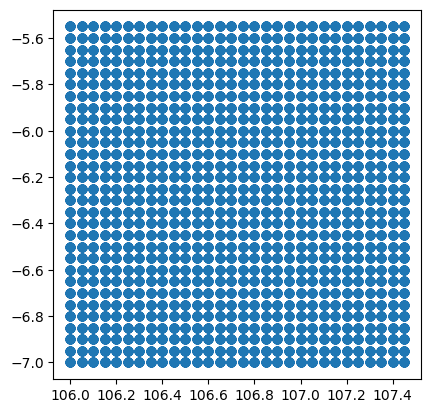

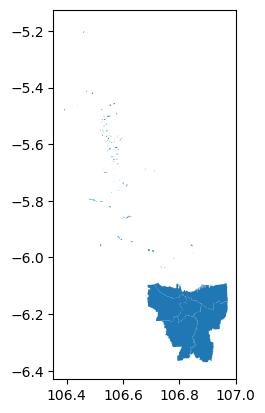

In [7]:
gdf_csv.plot()
gdf_shapefile.plot()

In [8]:
# spatial join
result = gpd.sjoin(gdf_csv, gdf_shapefile, how='inner', predicate='intersects')
result_pop = result[['longitude', 'latitude', 'tp', 'month', 'year', 'KABKOT', 'geometry', 'time']]

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 864 entries, 22006 to 53659
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   longitude  864 non-null    float64       
 1   latitude   864 non-null    float64       
 2   tp         864 non-null    float64       
 3   month      864 non-null    int32         
 4   year       864 non-null    int32         
 5   KABKOT     864 non-null    object        
 6   geometry   864 non-null    geometry      
 7   time       864 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), geometry(1), int32(2), object(1)
memory usage: 54.0+ KB


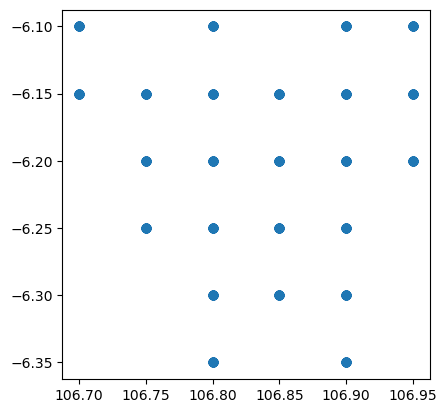

In [9]:
result_pop.plot()
result_pop.info()

Dissolved Result

In [10]:
# Dissolve berdasarkan 'KABKOT' dan 'month' dengan fungsi agregasi mean
dissolved_result = result_pop.dissolve(by=['KABKOT', 'month', 'year'], aggfunc='mean')

# Reset indeks untuk membuat kolom 'KABKOT' 'month', dan 'year' menjadi kolom
dissolved_result.reset_index(inplace=True)

In [11]:
# Tampilkan hasil
dissolved_result.head()

,KABKOT,month,year,geometry,longitude,latitude,tp,time
0,JAKARTA BARAT,1,2020,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,14.475730,2020-01-01
1,JAKARTA BARAT,1,2021,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,10.499982,2021-01-01
2,JAKARTA BARAT,1,2022,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,6.211204,2022-01-01
3,JAKARTA BARAT,2,2020,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,13.691263,2020-02-01
4,JAKARTA BARAT,2,2021,"MULTIPOINT ((106.70000 -6.15000), (106.70000 -...",106.75,-6.158333,14.319914,2021-02-01


In [12]:
dissolved_result_df = pd.DataFrame(dissolved_result)
dissolved_result_df = dissolved_result_df.drop(['geometry'], axis=1) #kolom geometry di hapus

In [13]:
#untuk mengurutkan file berdasarkan
dissolved_result_df = dissolved_result_df.sort_values(by=[ 'year', 'KABKOT', 'month'])

In [14]:
dissolved_result_df.to_csv("/Users/Jia/Downloads/data_skripsi/curah_hujan/dissolved_result_tp_3years.csv") 

#di save ke csv, jadi data rata" bulanan

In [15]:
polygon_result = gpd.sjoin(gdf_shapefile, dissolved_result, how='inner', predicate='intersects')

In [16]:
print(polygon_result.columns)

Index(['PROVNO', 'KABKOTNO', 'PROVINSI', 'KABKOT_left', 'geometry',
       'index_right', 'KABKOT_right', 'month', 'year', 'longitude', 'latitude',
       'tp', 'time'],
      dtype='object')


Grafik Time Series

In [17]:
import calendar

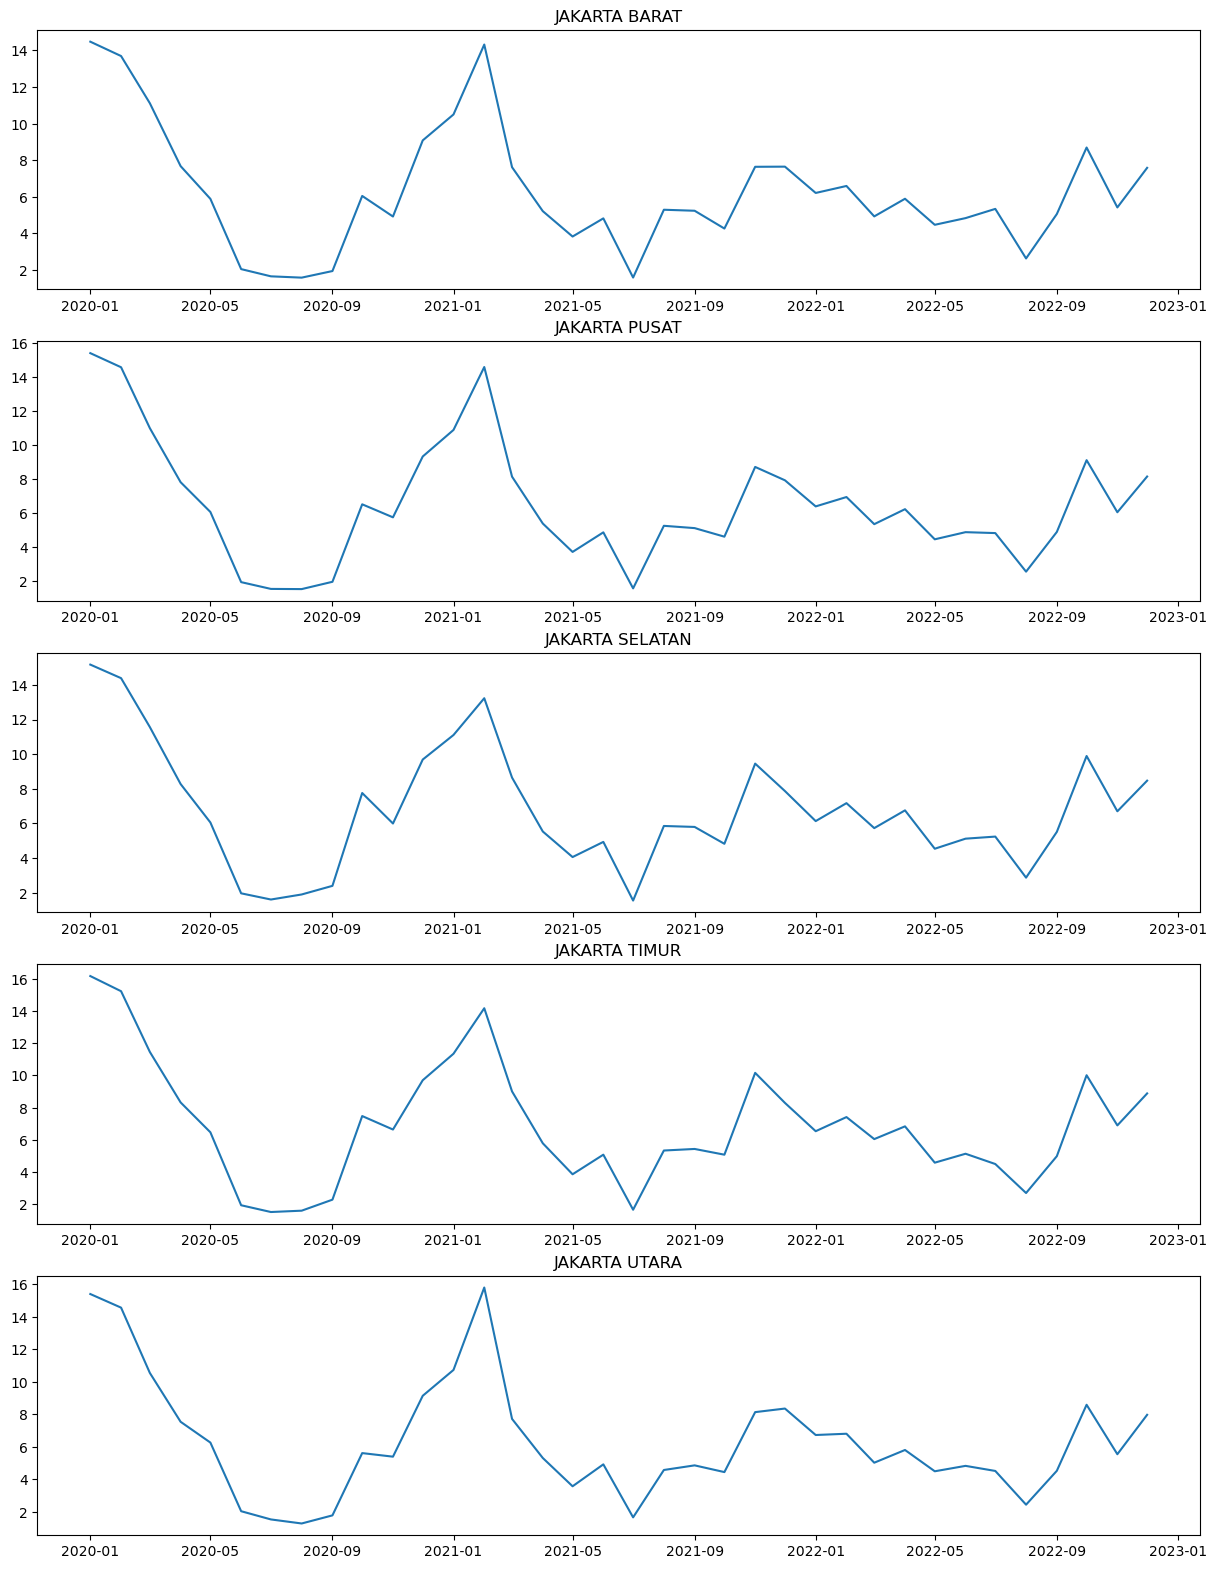

In [18]:
fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())
dissolved_result_df = dissolved_result_df.set_index('time')

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    fig.add_subplot(15, 1, ax)
    plt.plot(data_city['tp'])
    plt.title(city)
    #ax.set_title(f'{city}')

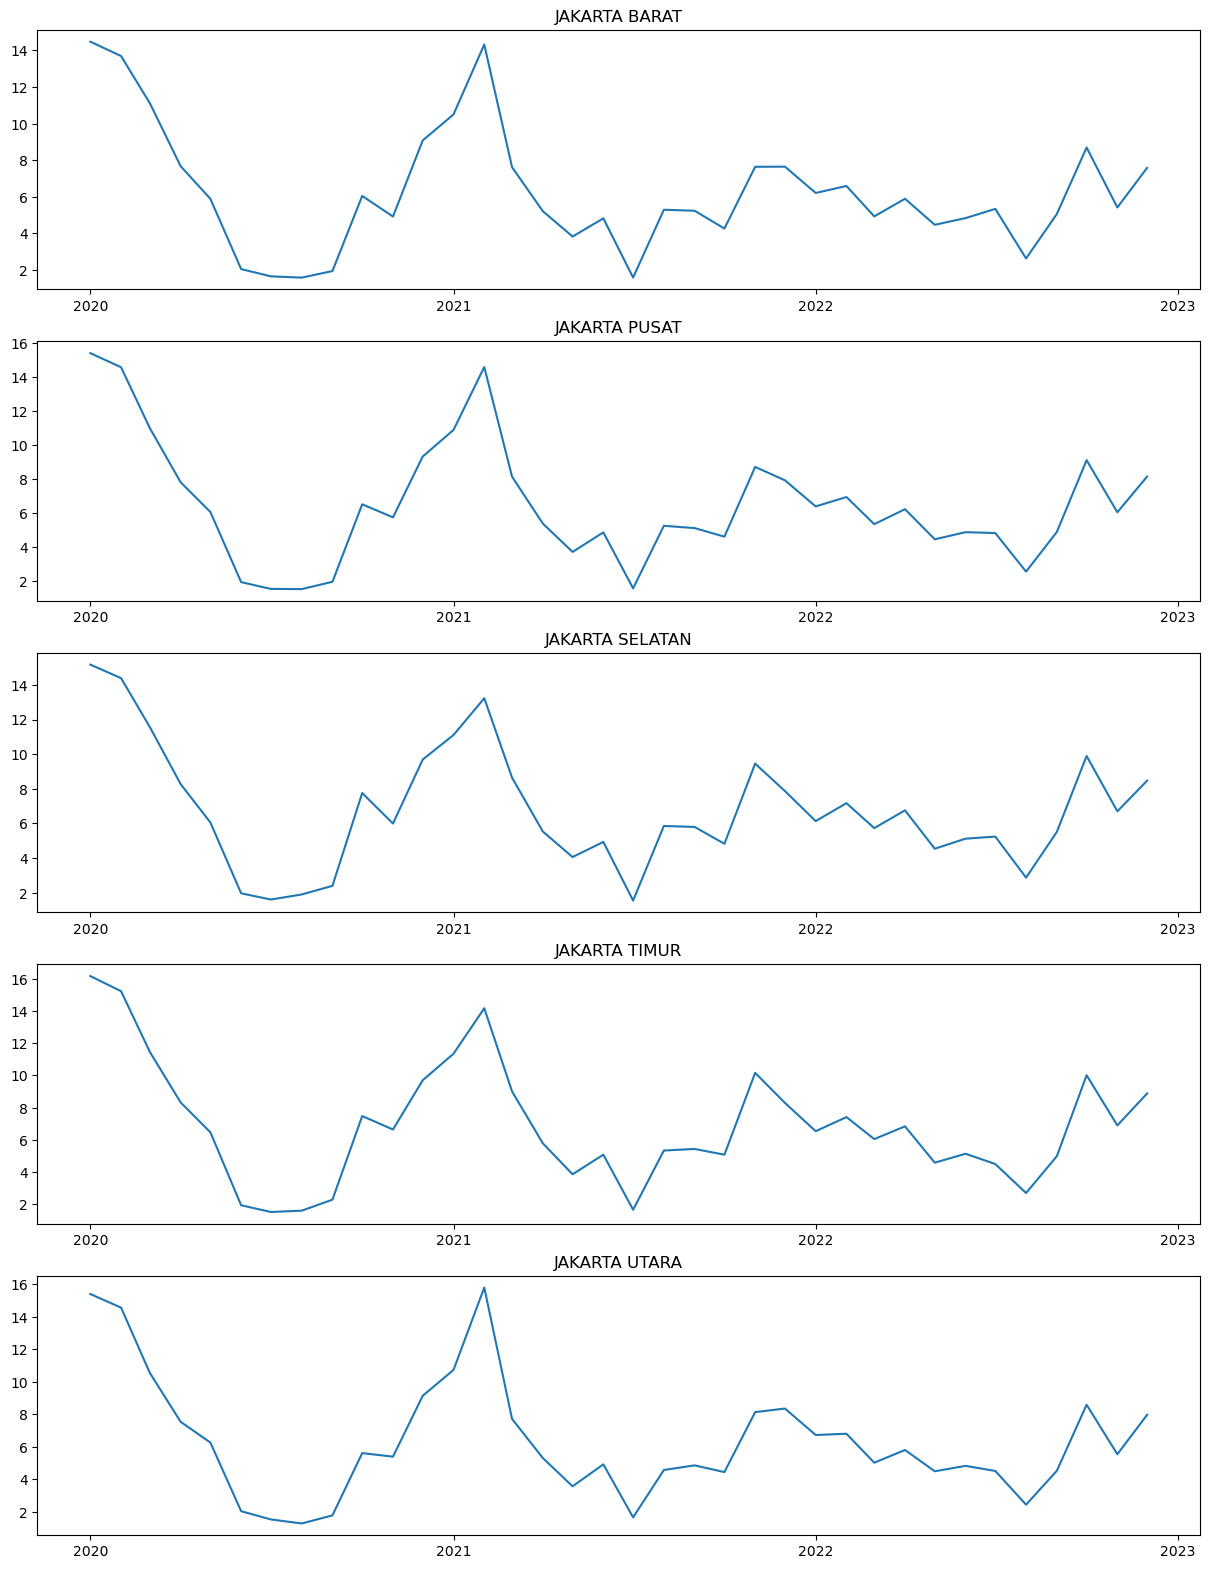

In [19]:
fig  = plt.figure(figsize=(15,60))
cities = list(dissolved_result_df['KABKOT'].unique())

import matplotlib.dates as mdates
from matplotlib.axis import Axis

# Iterate through each month and plot the data
for city, ax in zip(cities, range(1,6)):
    # Filter data for the current wilayah admin
    data_city = dissolved_result_df[dissolved_result_df['KABKOT'] == city]

    # Plot the map for the current kabkot
    axes = fig.add_subplot(15, 1, ax)
    plt.plot(data_city['tp'])
    axes.xaxis.set_major_locator(mdates.YearLocator())
    axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title(city)